<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/neb_al_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installation of packages

In [ ]:
!pip install -q git+https://github.com/saurabhsivakumar/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 8.2MB/s 
     |████████████████████████████████| 6.7MB 16.7MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 2.1MB 53.1MB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
     |████████████████████████████████| 110.5MB 64kB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 512kB 51.0MB/s 
     |████████████████████████████████| 3.8MB 49.3MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompati

#### Build the NEBcalculator class, construct geometry and train with the active learner

In [ ]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import TrajectoryReader,Trajectory
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 


Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 22.2 seconds


In [ ]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()
      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        print('BUILDING INITIAL')
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=100)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 
      """
      
      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
      
    def get_trajectory(self, filename):
      trajectory = Trajectory(filename + ".traj")
      atom_list = []
      for atom in trajectory:
        atom_list.append(atom)
      return atom_list

In [ ]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc,"parent_database")
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    print('BUILDING INITIAL')
    qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    print('BUILDING FINAL')
    qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
    #initial_slab = read("/content/parent_initial.traj")
    #final_slab = read("/content/parent_final.traj")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8998   652138.3125     +  0.0919
      2          0.0006          3.7510   603317.4375     +  0.0713
      3          0.0004          3.5959   554442.8750     +  0.0663


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      4          0.0011          7.5501  2444271.2500        0.0763
      5          0.0017          4.2625   779070.1875        0.0792
      6          0.0018          3.5735   547566.4375     +  0.0951
      7          0.0018          3.3674   486215.4375     +  0.1113
      8          0.0018          3.2979   466369.8438     +  0.1111
      9          0.0018          3.2704   458625.0312     +  0.1094
     10          0.0018          3.2576   455046.0000     +  0.1139
     11          0.0018          3.2523   453545.8750     +  0.1069
     12          0.0018          3.2507   453112.2188     +  0.0212
     13          0.0018          3.2507   453112.2188     +  0.1042
     14          0.0018          3.2283   446880.5625     +  0.1122
     15          0.0016          3.2150   443223.4375     +  0.1054
     16          0.0014          3.2092   441604.5938     +  0.1094
     17          0.0012          3.2073   441096.1562     +  0.1069
     18          0.0010          3.2026   439796

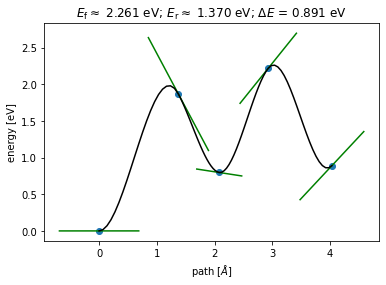

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0690          5.1773        2.6135     +  0.1737
      2          0.2045          1.6707        0.0749     +  0.1548


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0736          1.3804        0.0399     +  0.1385
      4          0.0831          1.1631        0.0298     +  0.1264
      5          0.0377          0.6726        0.0095     +  0.1365
      6          0.0112          0.5624        0.0062     +  0.1483
      7          0.0043          0.4422        0.0038     +  0.1485
      8          0.0032          0.3667        0.0026     +  0.1489
      9          0.0024          0.3213        0.0020     +  0.1323
     10          0.0025          0.2853        0.0016     +  0.1429
     11          0.0023          0.2605        0.0013     +  0.1392
     12          0.0022          0.2533        0.0013     +  0.1322
     13          0.0022          0.2533        0.0013     +  0.1387
     14          0.0013          0.1780        0.0006     +  0.1343
     15          0.0013          0.1613        0.0005     +  0.1357
     16          0.0025          0.1450        0.0004     +  0.1398
     17          0.0035          0.1308        0

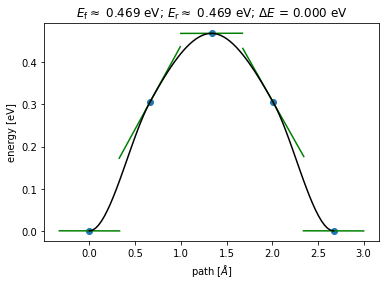

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8117          4.4538        3.8415     +  0.1449


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2173          1.4527        0.1241     +  0.1738
      3          0.0483          1.1566        0.0526     +  0.1417
      4          0.0606          0.9267        0.0358     +  0.1529
      5          0.0441          0.5706        0.0141     +  0.1703
      6          0.0275          0.4731        0.0092     +  0.1648
      7          0.0148          0.3767        0.0056     +  0.1705
      8          0.0111          0.3320        0.0043     +  0.1643
      9          0.0100          0.3094        0.0037     +  0.1643
     10          0.0093          0.2954        0.0034     +  0.1720
     11          0.0088          0.2862        0.0032     +  0.1784
     12          0.0085          0.2825        0.0031     +  0.1228
     13          0.0085          0.2825        0.0031     +  0.1865
     14          0.0056          0.2267        0.0020     +  0.1661
     15          0.0043          0.2048        0.0016     +  0.1657
     16          0.0041          0.1819        0

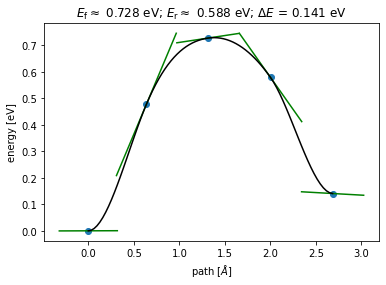

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8510          4.8626        7.4254     +  0.1820
      2          0.2877          1.3747        0.2689     +  0.1725


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0738          1.0024        0.0775     +  0.1750
      4          0.0512          0.8522        0.0538     +  0.1829
      5          0.0532          0.5349        0.0242     +  0.1897
      6          0.0284          0.4300        0.0139     +  0.2040
      7          0.0142          0.3354        0.0080     +  0.1915
      8          0.0108          0.3026        0.0064     +  0.2050
      9          0.0093          0.2855        0.0057     +  0.1944
     10          0.0082          0.2717        0.0051     +  0.2005
     11          0.0075          0.2594        0.0047     +  0.1949
     12          0.0071          0.2530        0.0044     +  0.2085
     13          0.0071          0.2530        0.0044     +  0.1940
     14          0.0055          0.1990        0.0027     +  0.2860
     15          0.0058          0.1794        0.0022     +  0.3127
     16          0.0049          0.1641        0.0019     +  0.2096
     17          0.0029          0.1532        0

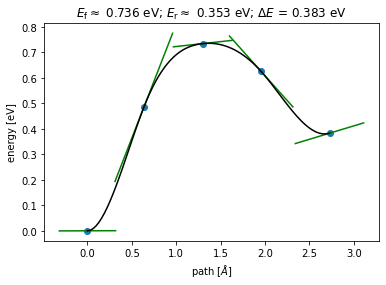

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.5535          4.5616        8.6990     +  0.2647


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2308          1.3079        0.3262     +  0.3022
      3          0.0549          1.0268        0.1211     +  0.2351
      4          0.0441          0.6805        0.0549     +  0.2620
      5          0.0229          0.4135        0.0197     +  0.2338
      6          0.0111          0.3286        0.0119     +  0.2299
      7          0.0084          0.2955        0.0096     +  0.2230
      8          0.0078          0.2749        0.0083     +  0.2453
      9          0.0074          0.2560        0.0072     +  0.2312
     10          0.0071          0.2415        0.0064     +  0.2209
     11          0.0069          0.2330        0.0060     +  0.2558
     12          0.0069          0.2302        0.0058     +  0.0290
     13          0.0069          0.2302        0.0058     +  0.2272
     14          0.0087          0.1807        0.0037     +  0.2400
     15          0.0100          0.1645        0.0032     +  0.2521
     16          0.0091          0.1553        0

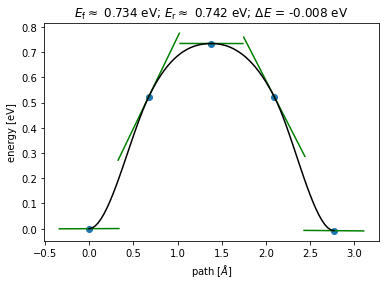

Terminating! Convergence criteria has been met


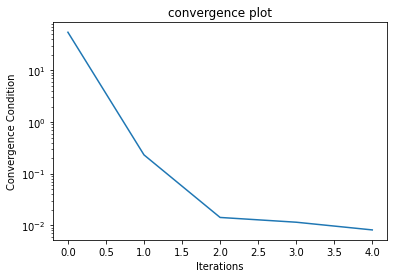

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.9032   653244.8750     +  0.0747
      2          0.0005          3.5059   527053.5625     +  0.0806
      3          0.0046          6.4722  1796179.1250        0.0851


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      4          0.0070          3.4502   510469.2500     +  0.0846
      5          0.0067          3.3763   488852.7500     +  0.1066
      6          0.0065          3.2916   464632.2500     +  0.1083
      7          0.0066          3.2493   452771.4062     +  0.1106
      8          0.0067          3.2385   449751.2812     +  0.1080
      9          0.0067          3.2352   448833.1875     +  0.1061
     10          0.0068          3.2340   448509.1250     +  0.2048
     11          0.0068          3.2336   448393.3125     +  0.1741
     12          0.0068          3.2335   448365.3750     +  0.0201
     13          0.0068          3.2335   448365.3750        0.1769
     14          0.0068          3.2316   447849.1562     +  0.1641
     15          0.0068          3.2312   447727.6250     +  0.1672
     16          0.0069          3.2302   447459.7500     +  0.1657
     17          0.0073          3.2269   446561.5625     +  0.1212
     18          0.0077          3.2189   444355

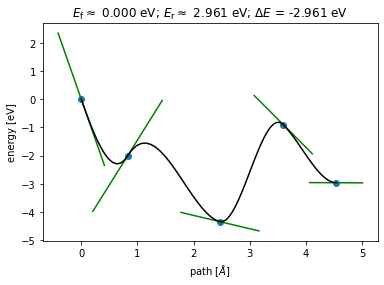

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6116          4.6796        2.4272     +  0.1160
      2          0.1856          1.5072        0.0876     +  0.1168


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0457          1.1593        0.0390     +  0.1256
      4          0.0538          0.8435        0.0219     +  0.1267
      5          0.0343          0.5156        0.0083     +  0.1378
      6          0.0143          0.4124        0.0049     +  0.1625
      7          0.0100          0.3357        0.0032     +  0.1350
      8          0.0097          0.2870        0.0024     +  0.1542
      9          0.0092          0.2549        0.0019     +  0.1381
     10          0.0087          0.2340        0.0016     +  0.1322
     11          0.0084          0.2226        0.0014     +  0.1435
     12          0.0083          0.2188        0.0014     +  0.0471
     13          0.0083          0.2188        0.0014     +  0.1337
     14          0.0076          0.1596        0.0008     +  0.1457
     15          0.0077          0.1394        0.0006     +  0.1346
     16          0.0070          0.1263        0.0005     +  0.1385
     17          0.0049          0.1156        0

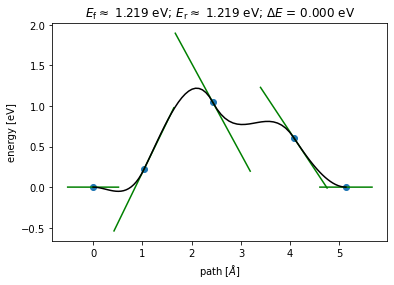

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6132          4.4930        4.5156     +  0.1463
      2          0.2015          1.3680        0.1529     +  0.1544


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0458          1.1528        0.0732     +  0.1457
      4          0.0563          0.8186        0.0397     +  0.1824
      5          0.0383          0.5649        0.0188     +  0.2532
      6          0.0210          0.4205        0.0100     +  0.2439
      7          0.0141          0.3259        0.0059     +  0.1721
      8          0.0118          0.2802        0.0043     +  0.1643
      9          0.0096          0.2472        0.0034     +  0.1807
     10          0.0086          0.2337        0.0030     +  0.1914
     11          0.0082          0.2277        0.0028     +  0.1795
     12          0.0081          0.2256        0.0028     +  0.1380
     13          0.0081          0.2256        0.0028     +  0.1664
     14          0.0066          0.1880        0.0019     +  0.1677
     15          0.0070          0.1718        0.0016     +  0.1656
     16          0.0068          0.1609        0.0014     +  0.1672
     17          0.0056          0.1525        0

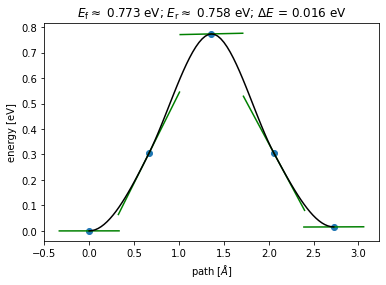

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4471          4.3951        6.6861     +  0.2215


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1693          1.3489        0.2366     +  0.1903
      3          0.0513          1.0887        0.1167     +  0.1831
      4          0.0455          0.6147        0.0401     +  0.1949
      5          0.0236          0.4034        0.0165     +  0.1891
      6          0.0149          0.3205        0.0101     +  0.2247
      7          0.0138          0.2745        0.0075     +  0.2382
      8          0.0134          0.2453        0.0060     +  0.1909
      9          0.0125          0.2271        0.0052     +  0.1920
     10          0.0117          0.2173        0.0047     +  0.2068
     11          0.0113          0.2126        0.0045     +  0.1895
     12          0.0111          0.2107        0.0044     +  0.0359
     13          0.0111          0.2107        0.0044     +  0.1892
     14          0.0074          0.1729        0.0029     +  0.2150
     15          0.0066          0.1548        0.0023     +  0.2065
     16          0.0064          0.1418        0

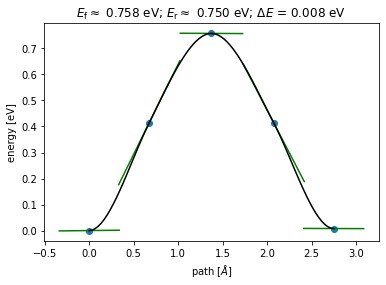

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.3272          4.3774        9.3570     +  0.1886


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2004          1.2880        0.3943     +  0.1920
      3          0.0388          0.9582        0.1415     +  0.2072
      4          0.0344          0.5302        0.0460     +  0.2162
      5          0.0217          0.3573        0.0206     +  0.2232
      6          0.0141          0.2999        0.0141     +  0.3876
      7          0.0118          0.2622        0.0107     +  0.3292
      8          0.0100          0.2271        0.0080     +  0.2834
      9          0.0088          0.2034        0.0064     +  0.2821
     10          0.0073          0.1813        0.0051     +  0.2776
     11          0.0067          0.1719        0.0045     +  0.2419
     12          0.0066          0.1687        0.0044     +  0.2515
     13          0.0066          0.1687        0.0044     +  0.2552
     14          0.0059          0.1320        0.0027     +  0.2228
     15          0.0058          0.1228        0.0024     +  0.2265
     16          0.0052          0.1151        0

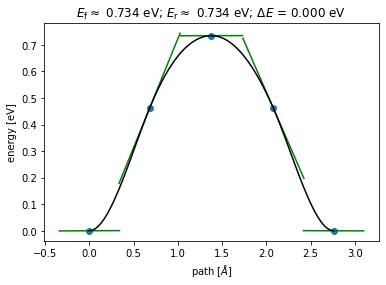

Terminating! Convergence criteria has been met


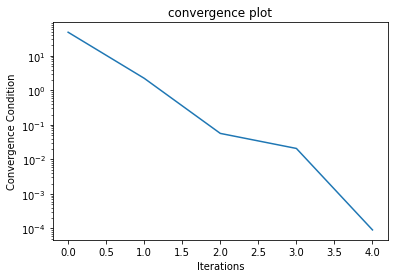

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8964   650987.0625     +  0.0727
      2          0.0279          3.6285   565394.6250     +  0.0839


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.2198          3.3610   536164.1875     +  0.0796
      4          0.1453          1.4298   110288.0625     +  0.0942
      5          0.1505          0.9081    59653.4219     +  0.1017
      6          0.1499          0.7892    50786.7344     +  0.1129
      7          0.1413          0.7260    44002.1641     +  0.1056
      8          0.1297          0.7220    40384.1523     +  0.1161
      9          0.1291          0.6921    38415.3906     +  0.1090
     10          0.1284          0.6800    37508.6172     +  0.1078
     11          0.1280          0.6754    37123.2578     +  0.1102
     12          0.1279          0.6743    37023.9844     +  0.0270
     13          0.1279          0.6743    37023.9492     +  0.1082
     14          0.1235          0.6555    34761.9844     +  0.1099
     15          0.1189          0.6488    33214.3477     +  0.1196
     16          0.1061          0.6478    30068.3281     +  0.1061
     17          0.0980          0.6090    26201

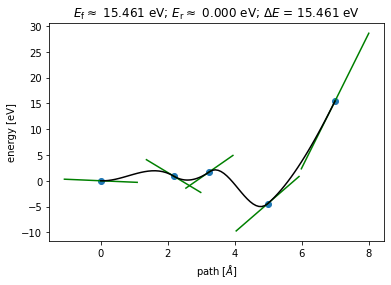

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.7514          4.5899        2.4177     +  0.1519
      2          0.2256          1.5331        0.0896     +  0.1302


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0503          1.1650        0.0351     +  0.1355
      4          0.0324          0.8109        0.0169     +  0.1215
      5          0.0179          0.5184        0.0068     +  0.1488
      6          0.0150          0.3782        0.0037     +  0.1679
      7          0.0096          0.3091        0.0024     +  0.1674
      8          0.0059          0.2598        0.0017     +  0.1330
      9          0.0043          0.2259        0.0013     +  0.1359
     10          0.0038          0.2086        0.0011     +  0.1421
     11          0.0036          0.2009        0.0010     +  0.1332
     12          0.0036          0.1985        0.0010     +  0.0289
     13          0.0036          0.1985        0.0010     +  0.1403
     14          0.0029          0.1556        0.0006     +  0.1366
     15          0.0025          0.1473        0.0005     +  0.1329
     16          0.0024          0.1375        0.0005     +  0.1410
     17          0.0032          0.1239        0

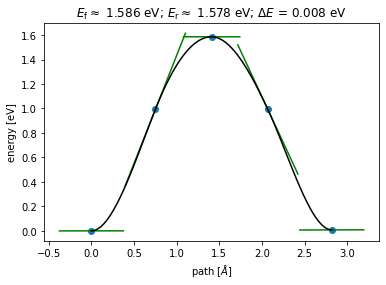

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6680          4.7561        4.8414     +  0.1234
      2          0.1778          1.2699        0.1262     +  0.1362


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0453          0.9645        0.0516     +  0.1464
      4          0.0342          0.5719        0.0187     +  0.1546
      5          0.0199          0.3874        0.0084     +  0.1702
      6          0.0141          0.3137        0.0054     +  0.1613
      7          0.0122          0.2729        0.0041     +  0.1651
      8          0.0099          0.2366        0.0031     +  0.1669
      9          0.0089          0.2222        0.0027     +  0.3183
     10          0.0083          0.2138        0.0025     +  0.2528
     11          0.0080          0.2089        0.0024     +  0.2349
     12          0.0079          0.2072        0.0023     +  0.0313
     13          0.0079          0.2072        0.0023     +  0.1996
     14          0.0067          0.1668        0.0015     +  0.2256
     15          0.0064          0.1517        0.0013     +  0.2131
     16          0.0061          0.1376        0.0010     +  0.1856
     17          0.0051          0.1259        0

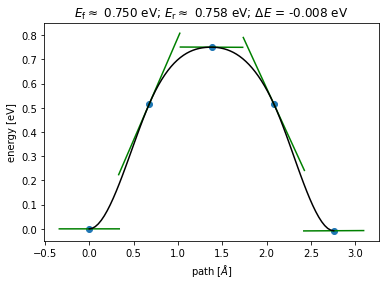

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4864          4.4851        7.0747     +  0.1584
      2          0.2454          1.1864        0.2735     +  0.1655


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0756          0.8623        0.0832     +  0.1747
      4          0.0496          0.6305        0.0431     +  0.2503
      5          0.0308          0.4398        0.0204     +  0.3233
      6          0.0174          0.3659        0.0133     +  0.2526
      7          0.0143          0.3263        0.0105     +  0.2894
      8          0.0129          0.2918        0.0084     +  0.2578
      9          0.0104          0.2582        0.0065     +  0.2496
     10          0.0085          0.2370        0.0054     +  0.2113
     11          0.0076          0.2280        0.0050     +  0.2335
     12          0.0073          0.2231        0.0048     +  0.2167
     13          0.0073          0.2231        0.0048     +  0.2132
     14          0.0058          0.1809        0.0032     +  0.1917
     15          0.0061          0.1660        0.0027     +  0.2014
     16          0.0051          0.1524        0.0022     +  0.2239
     17          0.0034          0.1387        0

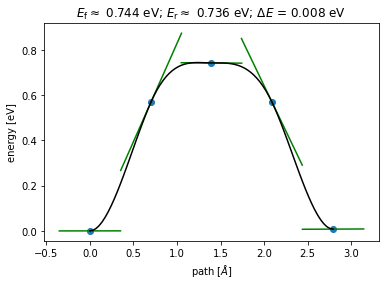

Terminating! Convergence criteria has been met


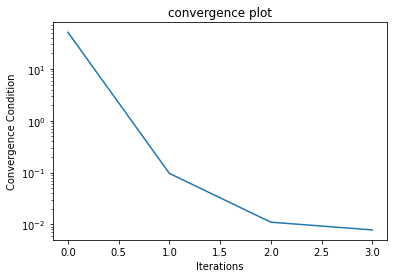

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8964   650984.3125     +  0.0745


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.0175          3.8373   631702.3125     +  0.0765
      3          0.3380          3.8989   774277.5000        0.0813
      4         18.7848          3.8989  378918304.0000        0.0881
      5          8.0671          3.8989  70413976.0000        0.0967
      6          3.8919          3.8989  16888680.0000        0.1057
      7          1.9200          3.8989  4603690.5000        0.1076
      8          1.1572          3.8989  2087246.2500        0.1132
      9          0.8166          3.8989  1366743.2500        0.1093
     10          0.6586          3.8989  1116733.0000        0.1073
     11          0.5984          3.8989  1035666.5625        0.1051
     12          0.5839          3.8989  1017297.3750        0.0308
     13          0.5839          3.8989  1017295.2500        0.1024
     14          0.2469          3.8989   717176.8750        0.1069
     15          0.2207          3.8989   704023.0000        0.1031
     16          0.0803          3.8989   65

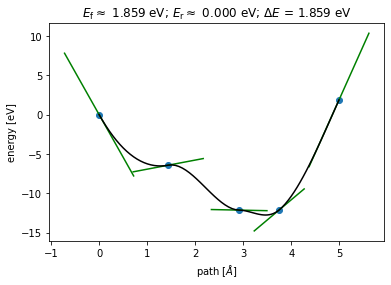

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.2716          4.7077        3.0874     +  0.1345


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1375          1.4758        0.1308     +  0.1392
      3          0.0121          1.0205        0.0516     +  0.1225
      4          0.0137          0.5573        0.0156     +  0.1511
      5          0.0028          0.4258        0.0090     +  0.1608
      6          0.0047          0.3258        0.0053     +  0.1365
      7          0.0018          0.2572        0.0033     +  0.1787
      8          0.0022          0.2234        0.0025     +  0.1349
      9          0.0025          0.1995        0.0020     +  0.1346
     10          0.0025          0.1841        0.0017     +  0.1337
     11          0.0024          0.1767        0.0015     +  0.1369
     12          0.0024          0.1747        0.0015     +  0.0163
     13          0.0024          0.1747        0.0015     +  0.1474
     14          0.0032          0.1420        0.0010     +  0.1341
     15          0.0040          0.1312        0.0009     +  0.1450
     16          0.0044          0.1225        0

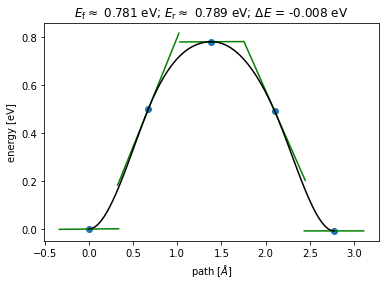

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.0632          4.0903        4.9183     +  0.1255
      2          0.1773          1.1821        0.2387     +  0.1391


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0379          0.7738        0.0694     +  0.1486
      4          0.0111          0.5020        0.0279     +  0.1548
      5          0.0063          0.3773        0.0157     +  0.1631
      6          0.0048          0.2982        0.0098     +  0.2169
      7          0.0038          0.2589        0.0074     +  0.2540
      8          0.0037          0.2349        0.0061     +  0.2496
      9          0.0035          0.2160        0.0051     +  0.2108
     10          0.0034          0.2040        0.0046     +  0.2255
     11          0.0035          0.1935        0.0041     +  0.2154
     12          0.0035          0.1867        0.0038     +  0.1691
     13          0.0035          0.1867        0.0038     +  0.1768
     14          0.0060          0.1545        0.0027     +  0.1744
     15          0.0071          0.1408        0.0023     +  0.1988
     16          0.0075          0.1274        0.0019     +  0.1721
     17          0.0051          0.1169        0

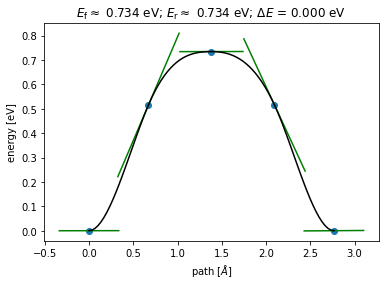

Terminating! Convergence criteria has been met


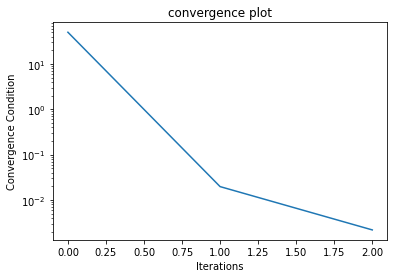

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8984   651670.1250     +  0.0742
      2          0.0011          3.4960   524059.0000     +  0.0773
      3          0.0015          3.7678   608734.4375        0.0819


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      4          0.0015          3.6697   577455.1250        0.1004
      5          0.0015          3.4287   504080.1250     +  0.0992
      6          0.0015          3.2959   465801.6875     +  0.1087
      7          0.0015          3.2442   451305.0938     +  0.1071
      8          0.0015          3.2321   447946.3438     +  0.1038
      9          0.0015          3.2260   446237.8125     +  0.1222
     10          0.0015          3.2210   444854.0938     +  0.1124
     11          0.0015          3.2182   444105.1250     +  0.1055
     12          0.0015          3.2175   443909.2812     +  0.0263
     13          0.0015          3.2175   443909.2500     +  0.1043
     14          0.0017          3.2353   448837.5625        0.1179
     15          0.0017          3.2145   443075.5000     +  0.1122
     16          0.0016          3.2090   441549.6875     +  0.1085
     17          0.0016          3.2072   441057.0625     +  0.1030
     18          0.0016          3.2067   440922

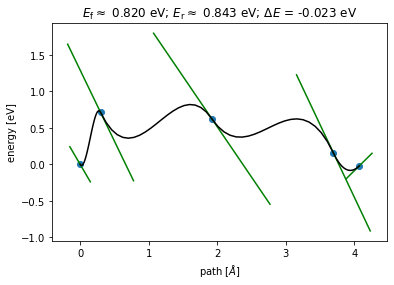

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9188          4.5948        2.2535     +  0.1082
      2          0.2930          1.5386        0.0899     +  0.1131


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0694          1.2064        0.0314     +  0.1200
      4          0.0263          1.0741        0.0233     +  0.1480
      5          0.0249          0.6510        0.0087     +  0.1377
      6          0.0134          0.4410        0.0040     +  0.1431
      7          0.0104          0.3249        0.0022     +  0.1408
      8          0.0086          0.2528        0.0013     +  0.1702
      9          0.0076          0.2118        0.0009     +  0.1443
     10          0.0070          0.1834        0.0007     +  0.1533
     11          0.0066          0.1696        0.0006     +  0.1468
     12          0.0065          0.1661        0.0006     +  0.0178
     13          0.0065          0.1661        0.0006     +  0.1385
     14          0.0042          0.1015        0.0002     +  0.1936
     15          0.0032          0.0917        0.0002     +  0.1933
     16          0.0026          0.0870        0.0002     +  0.1445
     17          0.0021          0.0805        0

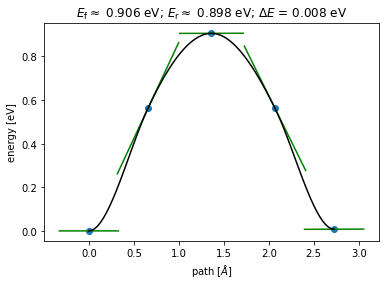

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8322          4.6947        4.1337     +  0.2001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2425          1.4861        0.1435     +  0.1865
      3          0.0453          1.1307        0.0519     +  0.1683
      4          0.0475          0.8012        0.0272     +  0.2031
      5          0.0281          0.4571        0.0089     +  0.1674
      6          0.0141          0.3036        0.0038     +  0.2035
      7          0.0069          0.2413        0.0023     +  0.2046
      8          0.0042          0.2060        0.0017     +  0.2103
      9          0.0035          0.1697        0.0011     +  0.1689
     10          0.0033          0.1461        0.0008     +  0.1828
     11          0.0032          0.1352        0.0007     +  0.1813
     12          0.0032          0.1322        0.0007     +  0.0745
     13          0.0032          0.1321        0.0007     +  0.1713
     14          0.0033          0.0927        0.0003     +  0.1723
     15          0.0031          0.0836        0.0003     +  0.2015
     16          0.0026          0.0785        0

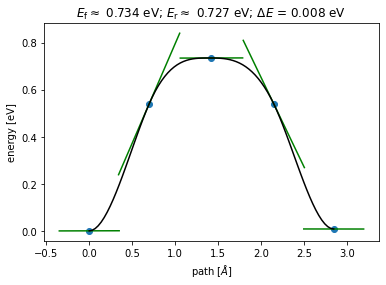

Terminating! Convergence criteria has been met


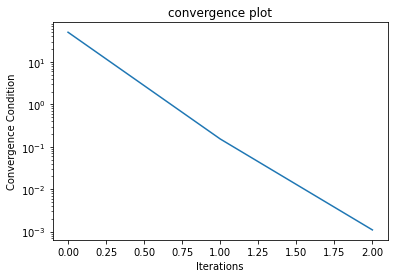

In [ ]:
force_calls = []
for i in range(5):
  # Define symmetry functions
  Gs = {}
  Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
  Gs["G2_rs_s"] = [0] * 4
  Gs["G4_etas"] = [0.005]
  Gs["G4_zetas"] = [1.0, 4.0]
  Gs["G4_gammas"] = [+1.0, -1]
  Gs["cutoff"] = 6.0

  # Training parameters for the active learning framework
  training_params = {
        "al_convergence": {"method": "neb_iter", "num_iterations": 7,"energy_tol":0.01},
        "samples_to_retrain": 1,
        "Gs": Gs,
        "morse": True,
        "forcetraining": True,
        "cores": 1,
        "optimizer": torch.optim.LBFGS,
        "batch_size": 1000,
        "criterion": CustomMSELoss,
        "num_layers": 3,
        "num_nodes": 20,
        "force_coefficient": 0.04,
        "learning_rate": 1e-2,
        "epochs": 200,
        "test_split": 0,
        "shuffle": False,
        "verbose": 1,
        "filename": "neb_ml_only_ml2relax_True",
        "file_dir": "./",
        "scheduler": {"policy": "CosineAnnealingWarmRestarts", "params":{"T_0":10, "T_mult":2}}
    }

  ml2relax = True
  parent_calc = Espresso(pw=500.0, 
                  calculation='scf',
                  kpts=(4,4,1),
                  xc='PBE')
  initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
  images = [initial]
  images.append(final)

  # Define AL scheme

  learner = AtomisticActiveLearner(
      training_data=images,
      training_params=training_params,
      parent_calc=parent_calc,
      ensemble=False
  )

  # Learn the corresponding atomistic method
  total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

  learner.learn(
      atomistic_method=NEBcalc(
          starting_images=images, 
          ml2relax=ml2relax, 
          intermediate_samples=total_neb_images-2), 
      query_strategy=random_query
    )
  force_calls.append(initial_force_calls+learner.parent_calls)

In [ ]:
print(force_calls)

[17, 17, 14, 11, 11]


In [ ]:
(force_calls[0]+force_calls[1]+force_calls[2]+force_calls[3]+force_calls[4])/5

14.0

In [ ]:
def neb_analysis(images, label, ax=None):
  nebtools = NEBTools(images)
  barrier, dE = nebtools.get_barrier()
  max_force = nebtools.get_fmax()
  fig = nebtools.plot_band(ax=ax)
  fig.savefig(label+'.png', dpi=300)
  return barrier, dE,max_force

#### Code to generate true NEB

In [ ]:
parent_calc = Espresso(pw=500.0, 
                  calculation='scf',
                  kpts=(4,4,1),
                  xc='PBE')
ml2relax = True
initial1, final1, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
total_neb_images = 5

In [ ]:
dft_counter = CounterCalc(Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE'),"DFT_database")
if not ml2relax:
  # Load previously computed relaxed states
  initial_slab1 = read("initial.traj", "-1")
  final_slab1 = read("final.traj", "-1")
else:
  initial.set_calculator(dft_counter)
  final.set_calculator(dft_counter)
  qn = BFGS(initial1, trajectory='original_parent_initial.traj', logfile='original_initial_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  qn = BFGS(final1, trajectory='original_parent_final.traj', logfile='original_final_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  initial_slab1 = read("original_parent_initial.traj", "-1")
  final_slab1 = read("original_parent_final.traj", "-1")

images2 = [initial_slab1]
for i in range(total_neb_images - 2):
    image = final_slab1.copy()
    image.set_calculator(dft_counter)
    images2.append(image)
images2.append(final_slab1)

neb = SingleCalculatorNEB(images2)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb1.traj')
qn.run(fmax=0.01,steps = 100)

      Step     Time          Energy         fmax
BFGS:    0 16:07:50   -66355.669132       11.7499
BFGS:    1 16:10:41   -66356.701676        8.2385
BFGS:    2 16:13:26   -66357.282979        5.9271
BFGS:    3 16:16:22   -66357.630797        4.2498
BFGS:    4 16:19:14   -66357.839857        2.9810
BFGS:    5 16:22:08   -66357.963481        1.9872
BFGS:    6 16:24:55   -66358.032969        1.1983
BFGS:    7 16:27:45   -66358.069550        0.5653
BFGS:    8 16:30:31   -66358.087780        0.6921
BFGS:    9 16:33:22   -66358.099045        0.8247
BFGS:   10 16:36:02   -66358.111443        0.8031
BFGS:   11 16:38:53   -66358.130986        0.5701
BFGS:   12 16:41:40   -66358.146574        0.2532
BFGS:   13 16:44:33   -66358.151128        0.1566
BFGS:   14 16:47:23   -66358.152292        0.1783
BFGS:   15 16:50:12   -66358.153505        0.2493
BFGS:   16 16:52:59   -66358.155306        0.2153
BFGS:   17 16:55:48   -66358.156714        0.0862
BFGS:   18 16:58:34   -66358.156797        0.0369
B

True

#### Image of the True NEB

Ef = 0.7299237970437388, dE = -0.00037946278462186456, force = 0.00959655670763901
Total number of force calls = 163


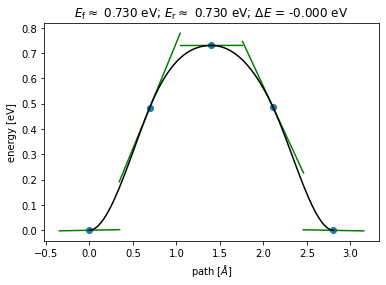

In [ ]:
images = read(f'actual_neb1.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE,force = neb_analysis(images, label="actual_neb")

print(f"Ef = {Ef}, dE = {dE}, force = {force}")
print(f"Total number of force calls = {initial_force_calls+dft_counter.force_calls}")

VERIFYING THE COUNT OF DFT CALLS USING ASE DATABASE

In [ ]:
from ase.db import connect

db = connect('DFT_database.db')
count = 0
for row in db.select():
    atoms = row.toatoms()
    count += 1
print(count)

161
